In [1]:
!pip install patool gdown --quiet

import warnings, os, patoolib, gdown

import tensorflow as tf

warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 2.0 MB/s eta 0:00:00


In [2]:
url = "https://drive.google.com/uc?id=1su3tKsJD0pp7FVaDEjr3vVLHfaN1cCLC"

root = "inputer.rar"

ontrue = !False

gdown.download(url, root, quiet=ontrue)

'inputer.rar'

In [3]:
root = "inputer.rar"

patoolib.extract_archive(root, outdir=".", verbosity=-1)

'.'

In [4]:
rooter = "/content/image"

outlen = os.listdir(rooter)

outlen

['Perempuan', 'Pria']

In [5]:
import tensorflow.keras.applications as applications

input_shape = (224, 224, 3); classes = len(outlen)

intnet = applications.EfficientNetB6(include_top=False, weights='imagenet', input_shape=input_shape, classes=classes)

165234480/165234480 [==============================] - 1s 0us/step


In [6]:
intnet.inputs[0]

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [7]:
intnet.outputs[0]

<KerasTensor: shape=(None, 7, 7, 2304) dtype=float32 (created by layer 'top_activation')>

In [8]:
from struct import unpack

marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()

    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]
            if len(data)==0:
                break


total = 0

for img in os.listdir(rooter):
  roti = os.path.join(rooter,img)
  for image in os.listdir(roti):
    imager = os.path.join(roti,image)
    image = JPEG(imager)
    try:
      image.decode()
    except:
      os.remove(imager)
      total += 1

total

340

In [9]:
i = os.listdir(os.path.join(rooter, "Pria"))

len(i)

461

In [10]:
i = os.listdir(os.path.join(rooter, "Perempuan"))

len(i)

417

In [11]:
import tensorflow.keras.utils as utils

orifile = utils.image_dataset_from_directory(
    rooter, subset="both",
    seed=10, image_size=(224, 224),
    validation_split=0.1,
    batch_size=18, label_mode="binary")

train, testi = orifile

Found 878 files belonging to 2 classes.
Using 791 files for training.
Using 87 files for validation.


In [12]:
for layer in intnet.layers[15:]:
  layer.trainable = True

In [13]:
import tensorflow as tf

class Matrit(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if logs.get("accuracy") >= 0.85 and logs.get("val_accuracy") >= 0.85:
      self.model.stop_training = True

matop = Matrit()

In [14]:
import tensorflow as tf

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation

inter = tf.keras.models.Sequential([
    RandomFlip("horizontal_and_vertical", input_shape=input_shape),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2),
    RandomTranslation(height_factor=0.2, width_factor=0.2)
])

model = tf.keras.models.Sequential([
    inter,
    intnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

plot = model.fit(train, validation_data=testi, epochs=10, callbacks=[matop])

Epoch 1/10
44/44 [==============================] - 146s 900ms/step - loss: 0.4586 - accuracy: 0.7927 - val_loss: 4.4990 - val_accuracy: 0.7356
Epoch 2/10
44/44 [==============================] - 32s 699ms/step - loss: 0.2908 - accuracy: 0.8875 - val_loss: 0.6111 - val_accuracy: 0.8506


In [15]:
i = tf.keras.utils.load_img(os.path.join(os.path.join(rooter, "Pria"), "pria (109).jpg"), target_size=input_shape)

i = tf.keras.utils.img_to_array(i)

i = tf.expand_dims(i, axis=0)

i.shape

TensorShape([1, 224, 224, 3])

In [16]:
model.predict(i)

1/1 [==============================] - 6s 6s/step


array([[0.8180012]], dtype=float32)

In [17]:
i = tf.keras.utils.load_img(os.path.join(os.path.join(rooter, "Perempuan"), "perempuan (1).jpg"), target_size=input_shape)

i = tf.keras.utils.img_to_array(i)

i = tf.expand_dims(i, axis=0)

model.predict(i)

1/1 [==============================] - 0s 39ms/step


array([[0.00152673]], dtype=float32)

In [18]:
t = "/content/image/Perempuan/perempuan (280).jpg"

i = tf.keras.utils.load_img(t, target_size=input_shape)

i = tf.keras.utils.img_to_array(i)

i = tf.expand_dims(i, axis=0)

model.predict(i)

1/1 [==============================] - 0s 38ms/step


array([[9.836403e-05]], dtype=float32)

In [19]:
import tensorflow.keras.utils as utils

def output(url):
  i = utils.load_img(url, target_size=(224, 224, 3))
  i = utils.img_to_array(i)
  i = tf.expand_dims(i, axis=0)
  result = "Pria" if model.predict(i) > 0.5 else "Perempuan"
  return result

output(t)

1/1 [==============================] - 0s 42ms/step


'Perempuan'

In [20]:
t = "/content/image/Pria/pria (102).jpg"

output(t)

1/1 [==============================] - 0s 64ms/step


'Pria'

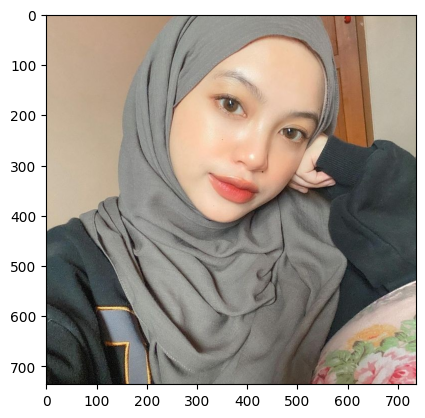

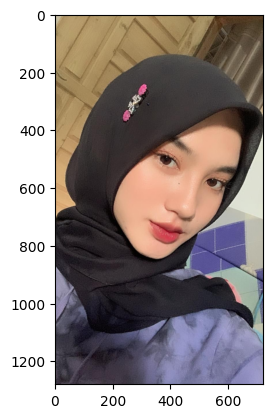

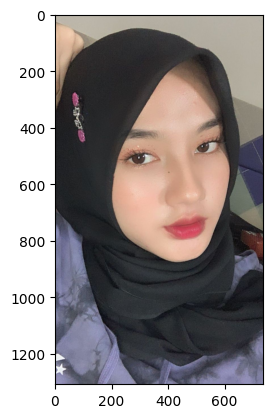

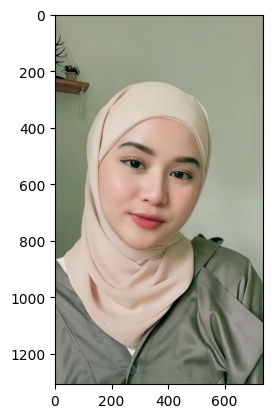

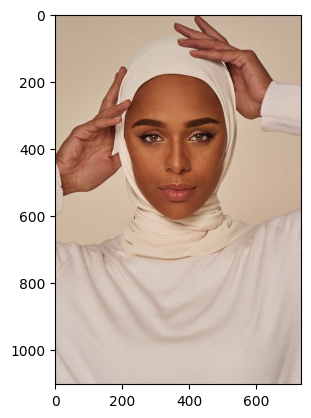

In [34]:
import matplotlib.pyplot as plt

import matplotlib.image as mpimg

for img in os.listdir(os.path.join(rooter, "Perempuan"))[:5]:
  t = os.path.join(rooter, os.path.join("Perempuan", img))
  img = mpimg.imread(t)
  plt.imshow(img)
  plt.show()

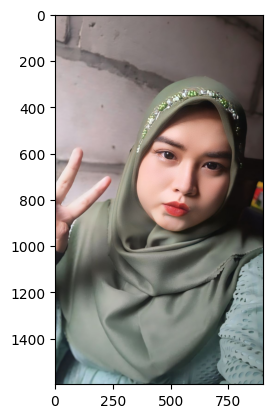

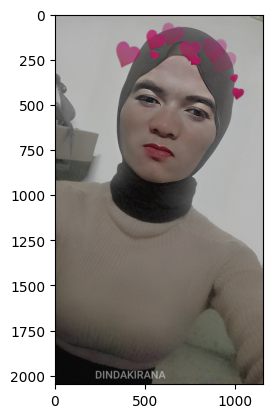

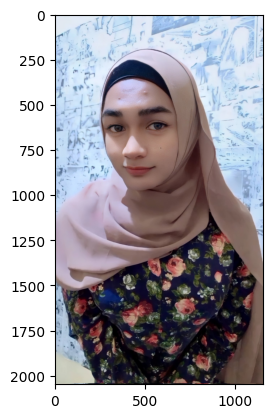

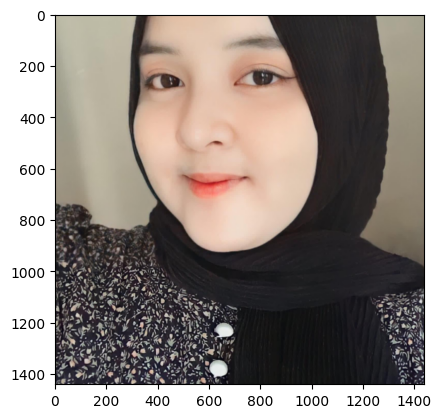

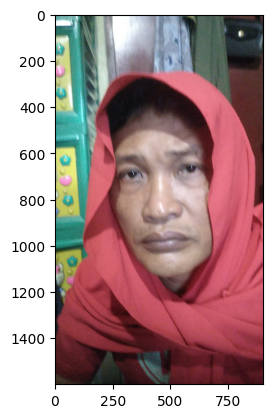

In [33]:
import matplotlib.pyplot as plt

import matplotlib.image as mpimg

for img in os.listdir(os.path.join(rooter, "Pria"))[:5]:
  t = os.path.join(rooter, os.path.join("Pria", img))
  img = mpimg.imread(t)
  plt.imshow(img)
  plt.show()